In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Activation:
    @staticmethod
    def sigmoid(z,derivative=False):
        if derivative:
            return z * (1 - z)
        return 1 / (1 + np.exp(-z))

    def relu(z,derivative=False):
        if derivative:
            return (z > 0).astype(int)
        return np.maximum(0,z)

    @staticmethod
    def softmax(z):
        return np.exp(z) / np.exp(z).sum()

In [ ]:
class Loss:
    def log(Y,A):
        return Y * np.log(A + 5e-3) + (1 - Y) * np.log(1 - A + 5e-3)

In [ ]:
train_x = np.array([[1,0],[0,0],[0,1],[1,1]]) * 10
train_y = np.array([0,1,0,1])
m = len(train_x)

layers = [3,3,1]
L = len(layers) - 1
optimizers = ['none','momentum','rmsprop','adam']

In [ ]:
def resetEnv():
    global thetaVec,gradVec,A,deltaVec,lr,cost_hist,grad,vd,sd

    thetaVec = [np.ones((layers[x + 1],layers[x])) for x in range(L)]
    gradVec = thetaVec.copy()
    A = [np.zeros((V,1)) for V in layers]
    deltaVec = A.copy()
    lr = 1e-3

    # Optimization parameters
    [vd,sd] = [thetaVec.copy() for x in range(2)]
    cost_hist = []
    grad = []

In [ ]:
def feedforward(X,epsilon = 0):
    A[0][1:] = X.reshape((len(X),1))
    for l in range(L):
        A[l + 1] = Activation.sigmoid((thetaVec[l] + epsilon) @ A[l])
    return A[L].sum()

In [ ]:
def calc_error(y):
    for l in range(L,0,-1):
        if l == L:
            deltaVec[l] = A[L] - y
        else:
            deltaVec[l] = thetaVec[l].T @ deltaVec[l + 1] * Activation.sigmoid(A[l],derivative=True)

In [ ]:
def J(m,net_loss):
    return ((-1 / m) * net_loss).sum()

In [ ]:
def check_gradient(x,y,epsilon):
    feedforward(x,epsilon)
    j_plus_loss = Loss.log(y,A[L])
    j_plus = J(m,j_plus_loss)

    feedforward(x,-epsilon)
    j_minus_loss = Loss.log(y,A[L])
    j_minus = J(m,j_minus_loss)

    return (j_plus - j_minus) / (2 * epsilon)

In [ ]:
def update_weights(lr,l,optimizer='momentum'):
    global vd,sd

    if optimizer == 'momentum':
        thetaVec[l] -= lr * vd[l]

    elif optimizer in ('rmsprop','adam'):
        numerator = gradVec[l] if optimizer == 'rmsprop' else vd[l]
        thetaVec[l] -= lr * (numerator / (np.sqrt(sd[l]) + 0.05))

    else:
        if l < L - 2:
            thetaVec[l] -= (lr / m) @ gradVec[l]
        else:
            thetaVec[l] -= (lr / m) * gradVec[l]

# Gradient Descent Optimization
---
### With gradient descent optimization, we can converge to the minima faster than the traditional gradient descent.

We will be going through 3 gradient descent algorithms (With and without optimization):
- Gradient Descent (GD)
- Momentum
- Root Mean Square propagation (RMSprop)
- Adaptive Moment estimation (Adam)

\\
With a constant learning rate $\alpha$, the traditional gradient descent converges slowly due to the non-changing speed. In addition, the convergence path fluctuates frequently before eventually converging to a local/global minima. To reduce fluctuations, [**Exponential Weighted Moving Average (EWMA)**](https://en.wikipedia.org/wiki/Moving_average#Weighted_moving_average) was utilized to smoothen the fluctuations, allowing faster convergence by accumulating previous parameters.

**Note that all parameters and hyperparameters are reset after running each optimization algorithm in order to observe their behaviour.**

\\
### Notations:
$V_{dW}\rightarrow$ Accumulated gradient for non-bias weights

$V_{dB}\rightarrow$ Accumulated gradient for bias weights

$S_{dB}\rightarrow$ Accumulated gradient for bias weights (RMSprop and Adam only)

$S_{dW}\rightarrow$ Accumulated gradient for bias weights  (RMSprop and Adam only)

$W\rightarrow$ Parameter matrix

$b\rightarrow$ Bias parameter vector

$\beta_{n}\rightarrow$ $n$-th momentum

$\epsilon \rightarrow$ A small arbitrary constant less than $1$

\\
The weight updates for the optimization algorithms are as follows, for current training batch $t$:

\\
**Momentum**

Initialize $V_{dW} = 0, V_{dB} = 0$
$$
    V_{dW}=\beta_1 V_{dW}+(1-\beta_1)dW\\
    V_{dB}=\beta_1 V_{dB}+(1-\beta_1)dB\\\\
$$

$$
    W = W - \alpha V_{dW}\\
    b = b - \alpha V_{dB}
$$

**RMSprop**

Initialize $V_{dW} = 0, V_{dB} = 0$
$$
    S_{dW}=\beta_2 S_{dW}+(1-\beta_2)dW^2\\
    S_{dB}=\beta_2 S_{dB}+(1-\beta_2)dB^2\\\\
$$

$$
    W = W - \alpha \frac{dW}{\sqrt{V_{dW}} + \epsilon}\\
    b = b - \alpha \frac{dB}{\sqrt{V_{dB}} + \epsilon}\\
$$

**Adam**

Initialize $V_{dW} = 0, V_{dB} = 0,S_{dW} = 0, S_{dB} = 0$

\
Momentum portion:
$$
    V_{dW}=\beta_1 V_{dW}+(1-\beta_1)dW\\
    V_{dB}=\beta_1 V_{dB}+(1-\beta_1)dB\\\\
$$

RMSprop portion:
$$
    S_{dW}=\beta_2 S_{dW}+(1-\beta_2)dW^2\\
    S_{dB}=\beta_2 S_{dB}+(1-\beta_2)dB^2\\\\
$$

Bias correction:
$$
    V_{dW}^{corrected}=\frac{V_{dW}}{1 - \beta_{1}^{t}},
    V_{dB}^{corrected}=\frac{V_{dB}}{1 - \beta_{1}^{t}}\\
    S_{dW}^{corrected}=\frac{S_{dW}}{1 - \beta_{2}^{t}},
    S_{dB}^{corrected}=\frac{S_{dB}}{1 - \beta_{2}^{t}}
$$

\\
Weights update:
$$
    W = W - \alpha \frac{V_{dW}^{corrected}}{\sqrt{S_{dW}^{corrected}} + \epsilon}\\
    b = b - \alpha \frac{V_{dB}^{corrected}}{\sqrt{S_{dB}^{corrected}} + \epsilon}\\
$$

An arbitrary constant $\epsilon$ can be seen in the formulae above, this is for numerical stability purposes, which prevents dividing by a small denominator.

Hyperparameters:

- Learning rate $\rightarrow 1e-3$
- Learning rate decay $\rightarrow 0.9$
- $\beta_1 \rightarrow 0.8$
- $\beta_2 \rightarrow 0.5$

With 100 epochs, the following results are produced:

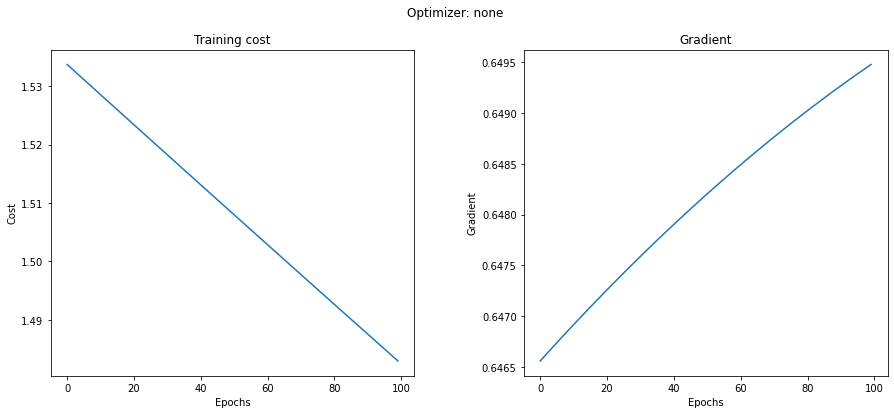


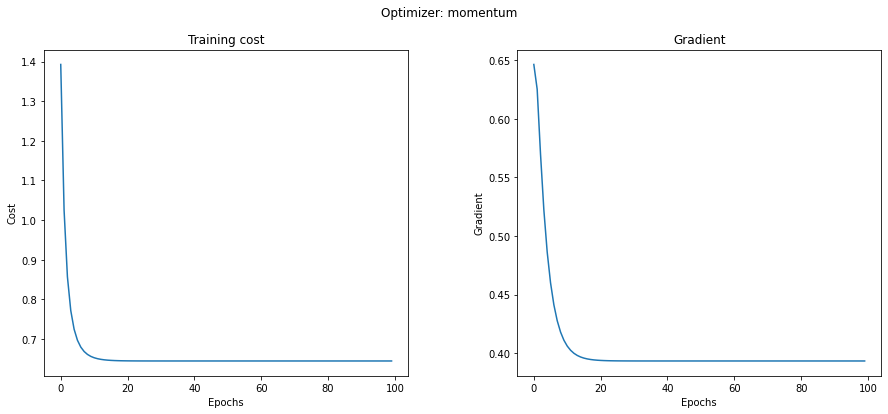


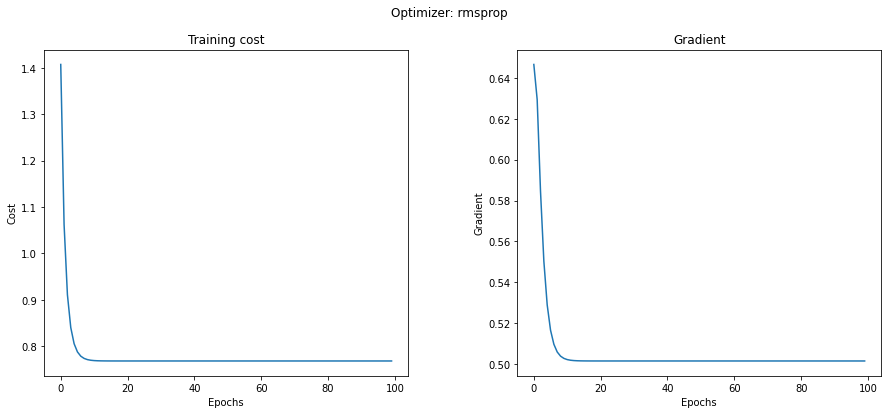


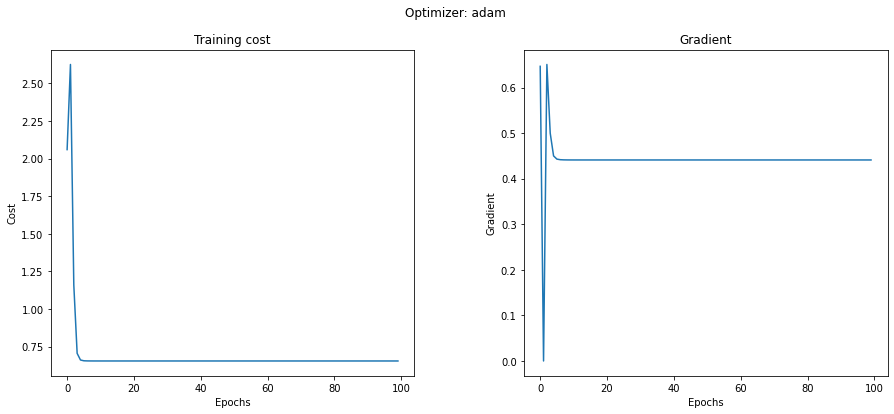

In [ ]:
def update_gradient(lr,optimizer='momentum',t=1,beta1=0.99,beta2=0.999):
    global gradVec,vd,sd

    for l in range(L - 1,0,-1):
        if l < L - 2:
            gradVec[l] = (deltaVec[l + 1] @ A[l].T)
        else:
            gradVec[l] = (deltaVec[l + 1] * A[l].T)
        gradVec[l][:,0] = deltaVec[l + 1].sum()


        if optimizer in ('momentum','rmsprop','adam'):
            k = int(optimizer in ('momentum','adam'))

            bias_correction_v = (1 - beta1 ** t) ** int(optimizer == 'adam')
            bias_correction_s = (1 - beta2 ** t) ** int(optimizer == 'adam')
            
            vd[l][:,1:] = (beta1 * vd[l][:,1:] + (1 - beta1) * gradVec[l][:,1:] ** (2 - k)) / bias_correction_v    # vdW
            vd[l][:,0] = (beta1 * vd[l][:,0] + (1 - beta1) * gradVec[l][:,0] ** (2 - k)) / bias_correction_v   # vdB

            if optimizer == 'adam':
                sd[l][:,1:] = (beta2 * sd[l][:,1:] + (1 - beta2) * gradVec[l][:,1:] ** 2) / bias_correction_s     # sdW
                sd[l][:,0] = (beta2 * sd[l][:,0] + (1 - beta2) * gradVec[l][:,0] ** 2) / bias_correction_s      # sdB

        update_weights(lr,l,optimizer)

In [ ]:
def lr_decay(rate,epochs):
    global lr
    lr *= rate ** np.sqrt(epochs)

In [ ]:
def train(epochs,decay_rate,calc_cost=False,check_grad=False,epsilon=0,optimizer='momentum',beta1=0.9,beta2=0.999):
    global thetaVec,grad,A,alg_count

    n_epochs = 0
    t = 0   # T-iterations

    while n_epochs < epochs:
        net_loss = 0
        if check_grad:
            grad.append(check_gradient(train_x[0],train_y[0],epsilon))

        for x,y in zip(train_x,train_y):
            t += 1
            feedforward(x)
            calc_error(y)

            if calc_cost:
                net_loss += Loss.log(y,A[L])
                
            update_gradient(lr,optimizer,t,beta1,beta2)

        n_epochs += 1

        if calc_cost:
            cost_hist.append(J(m,net_loss))

In [ ]:
def predict(X):
    feedforward(X)
    print(f"Input: {X}, Prediction: {int(A[L].sum() > 0.5)}, Probability: {A[L].sum()}")

In [ ]:
def analyse(optimizer):
    x_axis = [cost_hist,grad]
    y_label = ["Cost","Gradient"]
    title = ["Training cost","Gradient"]

    fig = plt.figure(figsize=(15,6))
    optimizer = optimizer or 'None'
    print(f'Optimizer: {optimizer}, Cost: {cost_hist[-1]}')
    for i,y in enumerate(y_label):
        fig.subplots_adjust(wspace=0.3)
        fig.add_subplot(1,2,i + 1)
        fig.suptitle(f'Optimizer: {optimizer}')
        plt.xlabel("Epochs")
        plt.ylabel(y)
        plt.title(title[i])
        plt.plot(x_axis[i])

In [ ]:
def compare():
    global optimizers

    for op in optimizers:
        resetEnv()
        train(100,0.9,check_grad=True,calc_cost=True,epsilon=1e-4,optimizer=op,beta1=0.8,beta2=0.5)
        analyse(op)

Optimizer: none, Cost: 1.4829927830743714
Optimizer: momentum, Cost: 0.644712906228653
Optimizer: rmsprop, Cost: 0.7682398073032705
Optimizer: adam, Cost: 0.6551733830281733


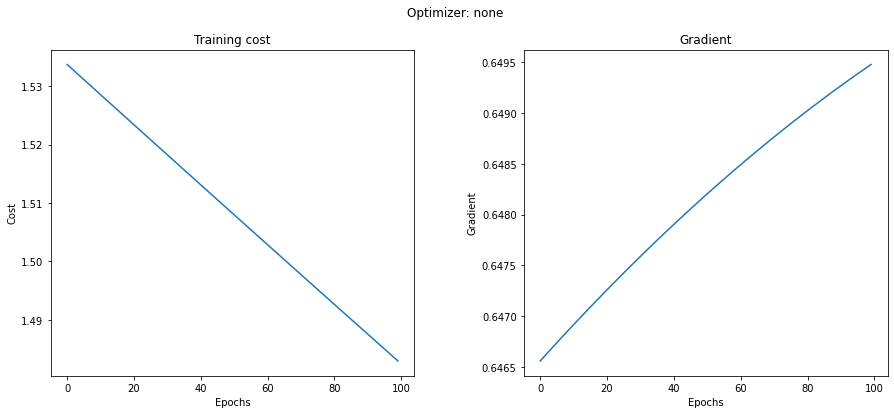

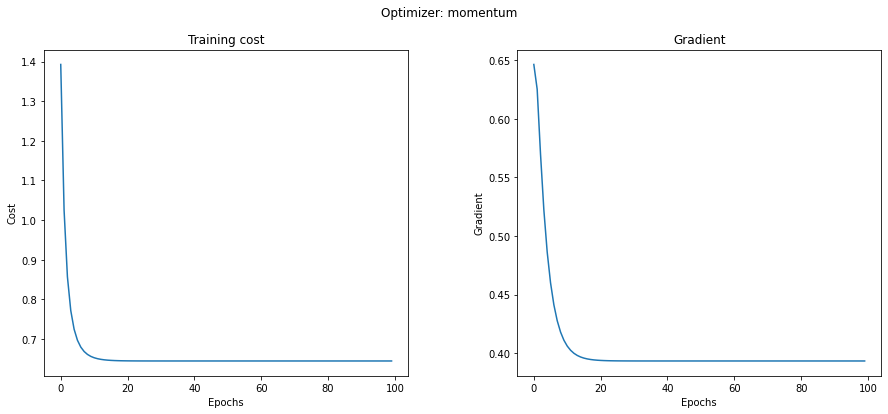

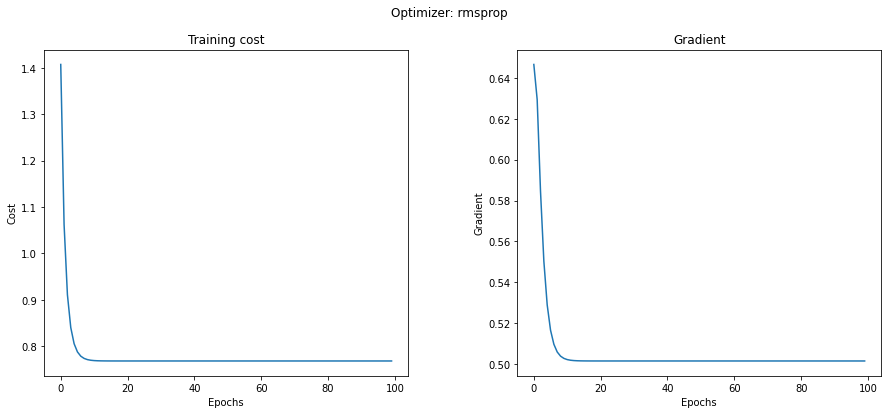

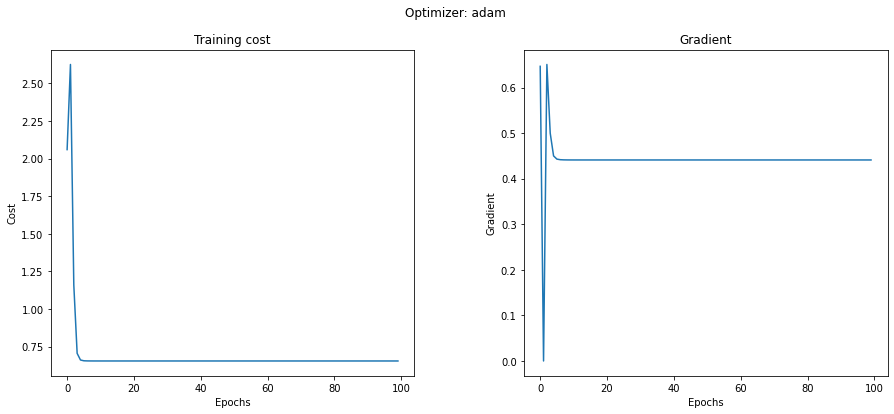

In [ ]:
compare()